Link to content in google drive: https://drive.google.com/drive/folders/1tVUz9gMh0rtJdHDSNMBcduqzLT0DWA0b?usp=sharing

# Preparation

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install timm

     |████████████████████████████████| 348kB 3.0MB/s 


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
from PIL import Image

path_to_content = '/content/drive/MyDrive/DL_project/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Install MMSegmentation

In [5]:
# ! unzip Swin-Transformer-Semantic-Segmentation-main.zip

In [6]:
%cd /content/drive/MyDrive/DL_project/Swin-Transformer-Semantic-Segmentation-main/
!pip install mmcv-full==1.3.0
!pip install -e .

/content/drive/MyDrive/DL_project/Swin-Transformer-Semantic-Segmentation-main
     |████████████████████████████████| 256kB 2.9MB/s 
     |████████████████████████████████| 194kB 12.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.0-cp37-cp37m-linux_x86_64.whl size=22584042 sha256=0d84fc6a0f4ed7d44b8cdb70ed7fd03d05be33d34f30a17adf4d2961950842c3
  Stored in directory: /root/.cache/pip/wheels/34/60/a1/e53785d2fbb520db58f2d77b4fca2b34435d2ef2015c18d608
Successfully built mmcv-full
Obtaining file:///content/drive/My%20Drive/DL_project/Swin-Transformer-Semantic-Segmentation-main
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=94d282e66f230133f95577e0822121ec20a3b61b78685c40526809f3d4f71075
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
  Running setup.py develop for mmsegmentation


In [7]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import mmcv_custom
# # Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.8.1+cu101 True
0.11.0


# Rebuild mask directory (from 3dim to 2dim masks)

In [8]:
# % cd /content/drive/MyDrive/DL_project/apples_segmentation/Apples_big/final/new_masks

In [9]:
# from PIL import Image

# for files in train + validation + test:
#     mask_name = files[1]
#     mask = Image.open(mask_name)
#     mask = mask.resize((600, 400))
#     mask1 = np.array(mask)[:,:,0]  
#     mask1[(mask1==2) | (mask1==3)] = 1 
#     mask1[mask1==4] = 2
#     # print(np.unique(mask1))  
#     mask2 = Image.fromarray(mask1)
#     mask2.save('../new_masks/'+mask_name) 
#     break

In [10]:
# % cd /content/drive/MyDrive/DL_project/apples_segmentation/Apples_big/final/new_imgs

In [11]:
# for files in train + validation + test:
#     img_name = files[0]
#     img = Image.open(img_name)
#     img = img.resize((600, 400))
#     # print(img.size)
#     img1 = np.array(img) 
#     img2 = Image.fromarray(img1)
#     img2.save('../new_imgs/'+img_name) 
#     # break

# Prepare dataset

In [12]:
%cd /content/drive/MyDrive/DL_project/apples_segmentation/

/content/drive/MyDrive/DL_project/apples_segmentation


In [20]:
import split
photos = split.collect_photos()
train, validation, test = split.split_dataset(photos, light_type = ['all', 'side'])
len(train), len(validation), len(test), train[0][0]

(82, 26, 37, '20_12_25_08_15_00_Canon_top_all_on.jpg')

In [14]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv

# convert dataset annotation to semantic segmentation map
data_root = path_to_content + 'apples_segmentation/Apples_big/final'
img_dir = 'new_imgs'
ann_dir = 'new_masks'
# define class and plaette for better visualization
classes = ('background', 'spoil', 'apple')
# classes = ('background', 'spoil1', 'spoil2', 'spoil3', 'apple')
palette = [[0, 0, 255], [255, 0, 0], [0, 255, 0]]


In [15]:
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  f.writelines(osp.splitext(elem[0])[0] + '\n' for elem in train)
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(osp.splitext(elem[0])[0] + '\n' for elem in validation)
with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
  f.writelines(osp.splitext(elem[0])[0] + '\n' for elem in test)


In [16]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class Apples_Dataset2(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

# Prepare for model

In [17]:
from mmcv import Config
from mmseg.apis import set_random_seed


cfg = Config.fromfile(path_to_content+'Swin-Transformer-Semantic-Segmentation-main/configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py')

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# cfg.model.backbone.use_checkpoint = True

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(classes)
cfg.model.auxiliary_head.num_classes = len(classes)

# Modify dataset type and path
cfg.dataset_type = 'Apples_Dataset2'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(600, 400), ratio_range=(0.5, 2)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(600, 400),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/test.txt'

cfg.load_from = path_to_content+'Swin-Transformer-Semantic-Segmentation-main/checkpoints/upernet_swin_tiny_patch4_window7_512x512.pth'
cfg.work_dir = path_to_content + 'apples_segmentation/work_dirs'

cfg.runner.max_iters = 2000 # need more
cfg.log_config.interval = 50
cfg.evaluation.interval = 200 # better more
# cfg.checkpoint_config.interval = 500

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        use_checkpoint=False),
    decode_head=dict(
        type='UPerHead',
        in_channels=[96, 192, 384, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        i

# Load and train model

In [18]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE


# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-05-27 17:10:12,632 - mmseg - INFO - Loaded 82 images


In [26]:
DO_TRAIN = False
if DO_TRAIN:
  train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2021-05-27 13:50:28,679 - mmseg - INFO - Loaded 26 images
2021-05-27 13:50:28,685 - mmseg - INFO - load checkpoint from /content/drive/MyDrive/DL_project/Swin-Transformer-Semantic-Segmentation-main/checkpoints/upernet_swin_tiny_patch4_window7_512x512.pth
2021-05-27 13:50:28,690 - mmseg - INFO - Use load_from_local loader
2021-05-27 13:50:29,051 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([150, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([150, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param wi

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.0 task/s, elapsed: 2s, ETA:     0s

2021-05-27 13:55:39,640 - mmseg - INFO - per class results:
2021-05-27 13:55:39,641 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.57 | 98.23 |
| spoil      | 63.3  | 77.11 |
| apple      | 68.24 | 81.67 |
+------------+-------+-------+
2021-05-27 13:55:39,647 - mmseg - INFO - Summary:
2021-05-27 13:55:39,648 - mmseg - INFO - 
+--------+-------+-------+------+
| Scope  | mIoU  | mAcc  | aAcc |
+--------+-------+-------+------+
| global | 76.04 | 85.67 | 92.7 |
+--------+-------+-------+------+
2021-05-27 13:55:39,656 - mmseg - INFO - Iter(val) [200]	mIoU: 0.7604, mAcc: 0.8567, aAcc: 0.9270
2021-05-27 13:56:56,895 - mmseg - INFO - Iter [250/2000]	lr: 6.451e-05, eta: 0:36:12, time: 1.587, data_time: 0.114, memory: 12425, decode.loss_seg: 0.0736, decode.acc_seg: 81.6738, aux.loss_seg: 0.0519, aux.acc_seg: 80.7888, loss: 0.1255
2021-05-27 13:58:14,310 - mmseg - INFO - Iter [300/2000]	lr: 6.542e-05, eta: 0:36:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.3 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:00:50,991 - mmseg - INFO - per class results:
2021-05-27 14:00:50,993 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.28 | 98.2  |
| spoil      | 64.51 | 73.3  |
| apple      | 72.73 | 91.53 |
+------------+-------+-------+
2021-05-27 14:00:50,994 - mmseg - INFO - Summary:
2021-05-27 14:00:51,000 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 78.17 | 87.68 | 93.55 |
+--------+-------+-------+-------+
2021-05-27 14:00:51,005 - mmseg - INFO - Iter(val) [400]	mIoU: 0.7817, mAcc: 0.8768, aAcc: 0.9355
2021-05-27 14:02:08,354 - mmseg - INFO - Iter [450/2000]	lr: 6.818e-05, eta: 0:31:15, time: 1.588, data_time: 0.115, memory: 12425, decode.loss_seg: 0.0560, decode.acc_seg: 80.4913, aux.loss_seg: 0.0364, aux.acc_seg: 79.7891, loss: 0.0924
2021-05-27 14:03:25,563 - mmseg - INFO - Iter [500/2000]	lr: 6.911e-05, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.1 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:06:02,319 - mmseg - INFO - per class results:
2021-05-27 14:06:02,320 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.56 | 98.48 |
| spoil      | 64.87 | 72.3  |
| apple      | 73.78 | 93.06 |
+------------+-------+-------+
2021-05-27 14:06:02,327 - mmseg - INFO - Summary:
2021-05-27 14:06:02,328 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 78.74 | 87.95 | 93.83 |
+--------+-------+-------+-------+
2021-05-27 14:06:02,336 - mmseg - INFO - Iter(val) [600]	mIoU: 0.7874, mAcc: 0.8795, aAcc: 0.9383
2021-05-27 14:07:19,622 - mmseg - INFO - Iter [650/2000]	lr: 7.190e-05, eta: 0:26:56, time: 1.588, data_time: 0.116, memory: 12425, decode.loss_seg: 0.0502, decode.acc_seg: 80.8615, aux.loss_seg: 0.0321, aux.acc_seg: 80.1793, loss: 0.0823
2021-05-27 14:08:36,916 - mmseg - INFO - Iter [700/2000]	lr: 7.284e-05, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.2 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:11:13,479 - mmseg - INFO - per class results:
2021-05-27 14:11:13,480 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.68 | 98.68 |
| spoil      | 67.7  | 75.75 |
| apple      | 75.2  | 91.83 |
+------------+-------+-------+
2021-05-27 14:11:13,481 - mmseg - INFO - Summary:
2021-05-27 14:11:13,486 - mmseg - INFO - 
+--------+------+-------+------+
| Scope  | mIoU | mAcc  | aAcc |
+--------+------+-------+------+
| global | 80.2 | 88.75 | 94.3 |
+--------+------+-------+------+
2021-05-27 14:11:13,491 - mmseg - INFO - Iter(val) [800]	mIoU: 0.8020, mAcc: 0.8875, aAcc: 0.9430
2021-05-27 14:12:30,842 - mmseg - INFO - Iter [850/2000]	lr: 7.567e-05, eta: 0:22:49, time: 1.588, data_time: 0.117, memory: 12425, decode.loss_seg: 0.0463, decode.acc_seg: 82.6611, aux.loss_seg: 0.0291, aux.acc_seg: 82.0148, loss: 0.0753
2021-05-27 14:13:48,335 - mmseg - INFO - Iter [900/2000]	lr: 7.663e-05, eta: 0:22:11, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.2 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:16:25,008 - mmseg - INFO - per class results:
2021-05-27 14:16:25,009 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.9  | 98.94 |
| spoil      | 67.86 | 76.51 |
| apple      | 74.51 | 90.02 |
+------------+-------+-------+
2021-05-27 14:16:25,010 - mmseg - INFO - Summary:
2021-05-27 14:16:25,014 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 80.09 | 88.49 | 94.33 |
+--------+-------+-------+-------+
2021-05-27 14:16:25,025 - mmseg - INFO - Iter(val) [1000]	mIoU: 0.8009, mAcc: 0.8849, aAcc: 0.9433
2021-05-27 14:17:42,173 - mmseg - INFO - Iter [1050/2000]	lr: 7.951e-05, eta: 0:18:47, time: 1.584, data_time: 0.112, memory: 12425, decode.loss_seg: 0.0424, decode.acc_seg: 81.5415, aux.loss_seg: 0.0266, aux.acc_seg: 80.8902, loss: 0.0691
2021-05-27 14:18:59,210 - mmseg - INFO - Iter [1100/2000]	lr: 8.048e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.0 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:21:35,848 - mmseg - INFO - per class results:
2021-05-27 14:21:35,849 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.84 | 98.67 |
| spoil      | 68.17 | 74.88 |
| apple      | 75.04 | 93.36 |
+------------+-------+-------+
2021-05-27 14:21:35,850 - mmseg - INFO - Summary:
2021-05-27 14:21:35,856 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 80.35 | 88.97 | 94.38 |
+--------+-------+-------+-------+
2021-05-27 14:21:35,866 - mmseg - INFO - Iter(val) [1200]	mIoU: 0.8035, mAcc: 0.8897, aAcc: 0.9438
2021-05-27 14:22:52,972 - mmseg - INFO - Iter [1250/2000]	lr: 8.343e-05, eta: 0:14:47, time: 1.584, data_time: 0.112, memory: 12425, decode.loss_seg: 0.0395, decode.acc_seg: 79.4575, aux.loss_seg: 0.0249, aux.acc_seg: 78.7958, loss: 0.0644
2021-05-27 14:24:10,298 - mmseg - INFO - Iter [1300/2000]	lr: 8.443e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.1 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:26:46,964 - mmseg - INFO - per class results:
2021-05-27 14:26:46,965 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.5  | 98.18 |
| spoil      | 67.66 | 78.3  |
| apple      | 73.82 | 89.78 |
+------------+-------+-------+
2021-05-27 14:26:46,966 - mmseg - INFO - Summary:
2021-05-27 14:26:46,973 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 79.66 | 88.75 | 94.02 |
+--------+-------+-------+-------+
2021-05-27 14:26:46,978 - mmseg - INFO - Iter(val) [1400]	mIoU: 0.7966, mAcc: 0.8875, aAcc: 0.9402
2021-05-27 14:28:04,493 - mmseg - INFO - Iter [1450/2000]	lr: 8.746e-05, eta: 0:10:50, time: 1.592, data_time: 0.120, memory: 12425, decode.loss_seg: 0.0388, decode.acc_seg: 81.3664, aux.loss_seg: 0.0239, aux.acc_seg: 80.7454, loss: 0.0627
2021-05-27 14:29:21,753 - mmseg - INFO - Iter [1500/2000]	lr: 8.849e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.0 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:31:58,458 - mmseg - INFO - per class results:
2021-05-27 14:31:58,460 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.74 | 98.64 |
| spoil      | 68.58 | 78.08 |
| apple      | 74.95 | 90.08 |
+------------+-------+-------+
2021-05-27 14:31:58,464 - mmseg - INFO - Summary:
2021-05-27 14:31:58,466 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 80.42 | 88.93 | 94.36 |
+--------+-------+-------+-------+
2021-05-27 14:31:58,473 - mmseg - INFO - Iter(val) [1600]	mIoU: 0.8042, mAcc: 0.8893, aAcc: 0.9436
2021-05-27 14:33:15,729 - mmseg - INFO - Iter [1650/2000]	lr: 9.165e-05, eta: 0:06:53, time: 1.587, data_time: 0.115, memory: 12425, decode.loss_seg: 0.0359, decode.acc_seg: 80.0703, aux.loss_seg: 0.0227, aux.acc_seg: 79.4142, loss: 0.0586
2021-05-27 14:34:33,122 - mmseg - INFO - Iter [1700/2000]	lr: 9.272e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 15.1 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:37:09,797 - mmseg - INFO - per class results:
2021-05-27 14:37:09,799 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.76 | 99.02 |
| spoil      | 68.88 | 77.6  |
| apple      | 74.89 | 89.2  |
+------------+-------+-------+
2021-05-27 14:37:09,800 - mmseg - INFO - Summary:
2021-05-27 14:37:09,805 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 80.51 | 88.61 | 94.43 |
+--------+-------+-------+-------+
2021-05-27 14:37:09,811 - mmseg - INFO - Iter(val) [1800]	mIoU: 0.8051, mAcc: 0.8861, aAcc: 0.9443
2021-05-27 14:38:27,153 - mmseg - INFO - Iter [1850/2000]	lr: 9.609e-05, eta: 0:02:56, time: 1.588, data_time: 0.117, memory: 12425, decode.loss_seg: 0.0353, decode.acc_seg: 80.0901, aux.loss_seg: 0.0219, aux.acc_seg: 79.4617, loss: 0.0572
2021-05-27 14:39:44,322 - mmseg - INFO - Iter [1900/2000]	lr: 9.728e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 14.3 task/s, elapsed: 2s, ETA:     0s

2021-05-27 14:42:24,366 - mmseg - INFO - per class results:
2021-05-27 14:42:24,368 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.92 | 98.87 |
| spoil      | 69.06 | 78.12 |
| apple      | 74.64 | 89.6  |
+------------+-------+-------+
2021-05-27 14:42:24,371 - mmseg - INFO - Summary:
2021-05-27 14:42:24,374 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 80.54 | 88.86 | 94.45 |
+--------+-------+-------+-------+
2021-05-27 14:42:24,381 - mmseg - INFO - Iter(val) [2000]	mIoU: 0.8054, mAcc: 0.8886, aAcc: 0.9445


# Visualise results

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from PIL import Image


img = mmcv.imread(data_root+'/'+img_dir+'/'+validation[0][0])
mask = Image.open(data_root+'/'+ann_dir+'/'+validation[0][1])

model.cfg = cfg
result = inference_segmentor(model, img)
# plt.figure(figsize=(8, 6))
# plt.imshow(mmcv.bgr2rgb(img))
plt.figure(figsize=(8, 6))
plt.imshow(mask)
show_result_pyplot(model, img, result, palette)

# Load and evaluate model

Use load_from_local loader


/content/drive/My Drive/DL_project/Swin-Transformer-Semantic-Segmentation-main/mmseg/models/segmentors/base.py:267: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


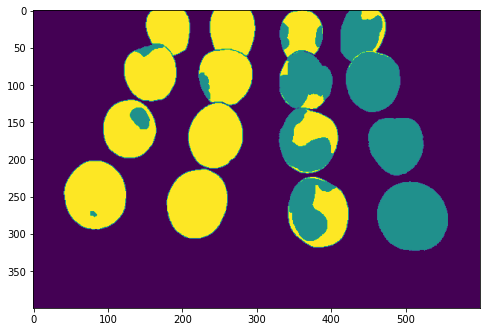

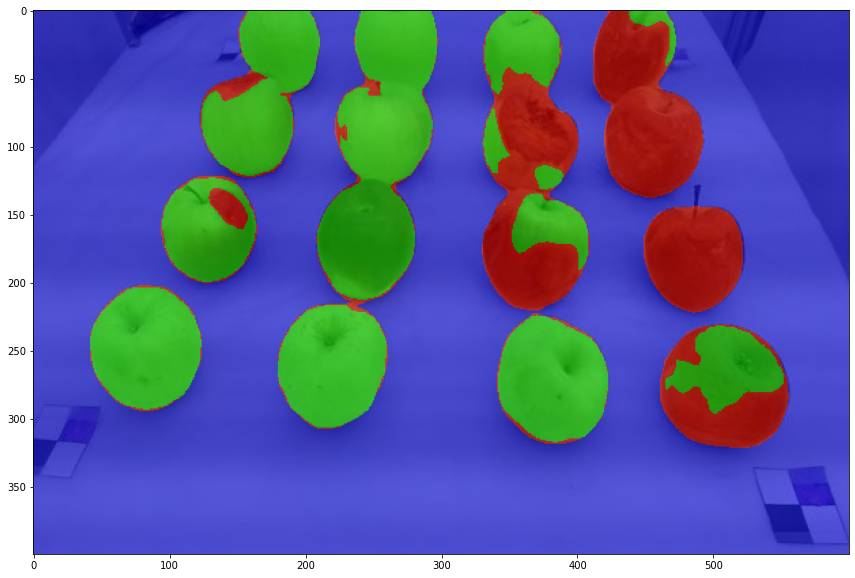

In [21]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

img = mmcv.imread(data_root+'/'+img_dir+'/'+test[0][0])
mask = Image.open(data_root+'/'+ann_dir+'/'+test[0][1])

config_file = cfg
checkpoint_file = cfg.work_dir + '/best_segmentator.pth'
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
plt.imshow(mask)
show_result_pyplot(model, img, result, palette)

# Environment

In [ ]:
# !which python # should return /usr/local/bin/python
# !python --version
# !echo $PYTHONPATH
# %env PYTHONPATH=

In [ ]:
# %%bash
# MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.12-Linux-x86_64.sh
# MINICONDA_PREFIX=/usr/local
# wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# chmod +x $MINICONDA_INSTALLER_SCRIPT
# ./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
# !which conda # should return /usr/local/bin/conda
# !conda --version
# !python --version
# ! conda create -n swin python=3.7 -y
# ! conda activate swin
# ! conda install pytorch==1.7.1 torchvision==0.8.2 cudatoolkit=10.1 -c pytorch
# ! pip install timm==0.3.2

In [ ]:
# %%writefile setup.sh

# export CUDA_HOME=/usr/local/cuda-10.1
# # git clone https://github.com/NVIDIA/apex
# pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
# !sh setup.sh
# ! pip install opencv-python==4.4.0.46 termcolor==1.1.0 yacs==0.1.8
# ! python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345 main.py --eval \
# --cfg configs/swin_tiny_patch4_window7_224.yaml --resume swin_tiny_patch4_window7_224.pth --data-path ../arctic_classification_all